In [44]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from helper_functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 72

## Subtask 1
#### Load data, create windows and do PCA om them

Shape of data: (14002, 10)
Maximum number of pedestrians in one cell 200.0
Minimum number of pedestrians in one cell 0.0


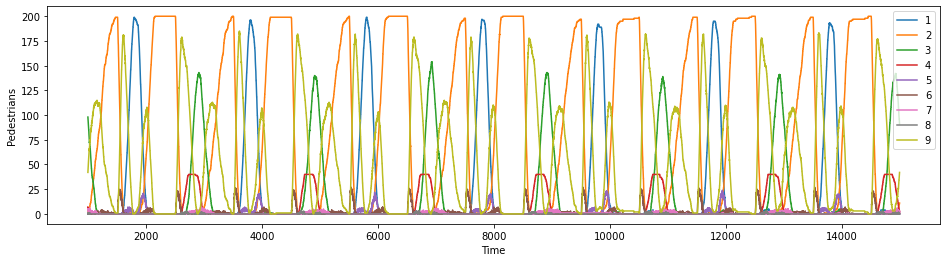

In [3]:
mi = np.genfromtxt('data/MI_timesteps.txt',skip_header=1000)
max_ped = np.max(mi[:, 1:])
min_ped = np.min(mi[:, 1:])
print(f'Shape of data: {mi.shape}')
print(f'Maximum number of pedestrians in one cell {np.max(mi[:, 1:])}')
print(f'Minimum number of pedestrians in one cell {np.min(mi[:, 1:])}')
plt.figure(figsize=(16,4))
for i in range(1,10):
    plt.plot(mi[:,0],mi[:,i], label=i)

plt.xlabel('Time')
plt.ylabel("Pedestrians")
plt.legend()
plt.show()

In [4]:
window_length = 351
delayed_list = []
for i in range(len(mi)-window_length+1):
    delayed_list.append(mi[i:i+window_length, 1:4].flatten())
delayed = np.vstack(delayed_list)
print(f'Shape of generated data: {delayed.shape}')

Shape of generated data: (13652, 1053)


In [5]:
pca = PCA(n_components=3, random_state=42)
pca.fit(delayed)
for i in range(len(pca.explained_variance_ratio_)):
    exp_var = np.sum(pca.explained_variance_ratio_[:i+1])
    print(f'\"Energy\" (explained variance) from including {i+1} components: {round(exp_var, 3)} ')
transformed = pca.transform(delayed)
print(f'Shape of tranformed data: {transformed.shape}')

"Energy" (explained variance) from including 1 components: 0.458 
"Energy" (explained variance) from including 2 components: 0.689 
"Energy" (explained variance) from including 3 components: 0.829 
Shape of tranformed data: (13652, 3)


## Subtask 2
#### Plot embedding things

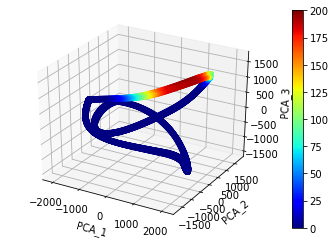

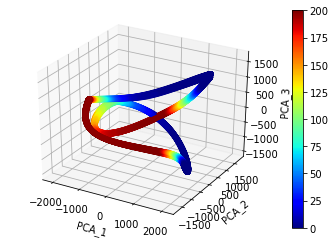

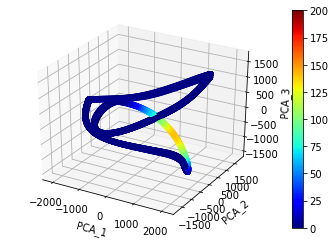

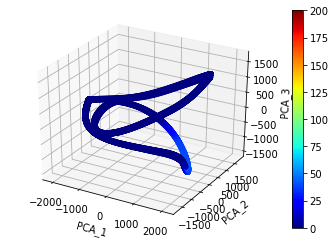

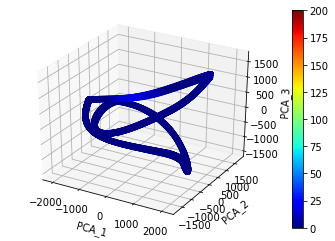

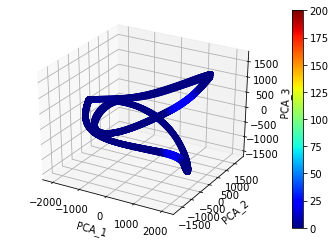

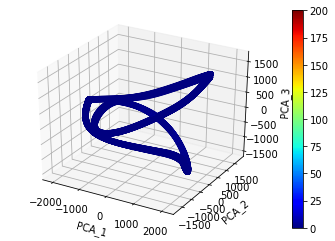

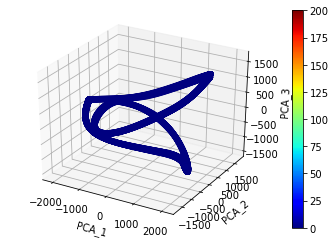

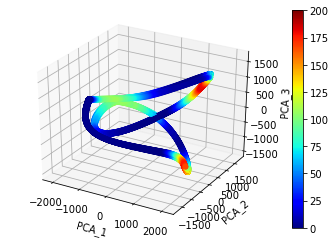

In [6]:
normalize = matplotlib.colors.Normalize(vmin=min_ped, vmax=max_ped)

for i in range(9):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    t = ax.scatter(transformed[:,0], transformed[:,1], transformed[:,2],  c = mi[:len(transformed), i + 1], cmap='jet', norm = normalize)
    ax.set_xlabel("PCA_1")
    ax.set_ylabel("PCA_2")
    ax.set_zlabel("PCA_3")
    plt.colorbar(t)
#plt.show()

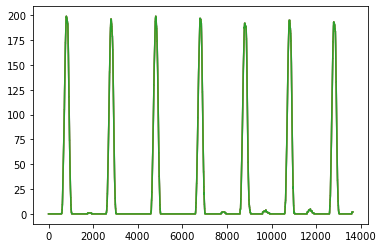

In [7]:
plt.plot(delayed[:,0])
plt.plot(delayed[:,3])
plt.plot(delayed[:,6])

## Subtask 3
### Plot arclength thingy

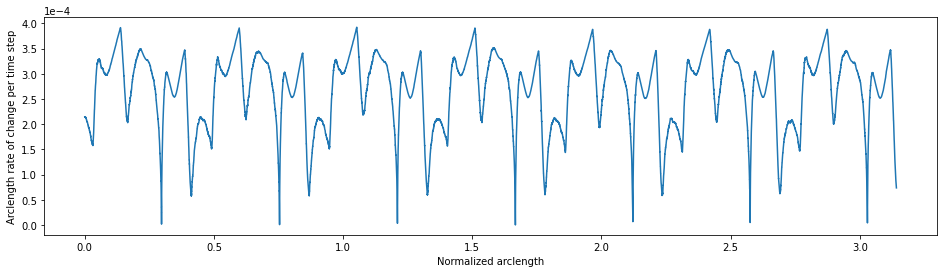

In [17]:
plt.figure(figsize=(16,4))
arclengthdot = np.linalg.norm(np.diff(transformed, axis=0),axis=1)
#x = np.linspace(0, np.pi, len(arclengthdot))
arclength = np.cumsum(arclengthdot)
normalization = np.pi/arclength[-1]
arclength *= normalization
arclengthdot *= normalization
plt.plot(arclength,arclengthdot)
plt.xlabel('Normalized arclength')
plt.ylabel('Arclength rate of change per time step')
plt.gca().ticklabel_format(style='sci',scilimits=(-3,5))

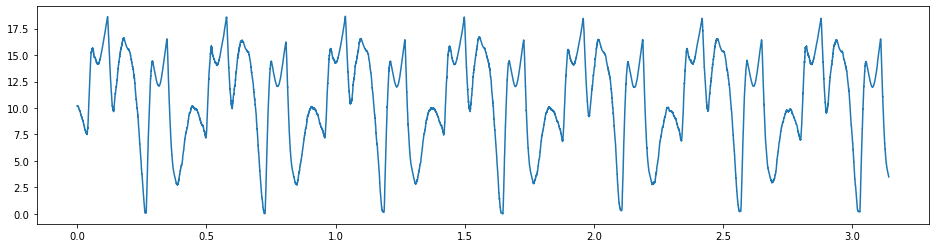

In [11]:
plt.figure(figsize=(16,4))
plt.plot(np.linspace(0, np.pi, len(arclengthdot)), arclengthdot)

### Learn the arclength velocity

In [20]:
import math
# Set up and train
rbf_periodic = RBF(200, 0.05, periodic=True)
rbf_nonperiodic = RBF(200, 0.1)
rbf_periodic.fit(arclength, arclengthdot)
rbf_nonperiodic.fit(arclength, arclengthdot)



pi = math.pi
# Forecast
next_weeks = np.linspace(pi, 3*pi, 2*len(arclengthdot))

periodic_train = rbf_periodic.predict(arclength)
periodic_pred = rbf_periodic.predict(next_weeks)

nonperiodic_train = rbf_nonperiodic.predict(arclength)
nonperiodic_pred = rbf_nonperiodic.predict(next_weeks)

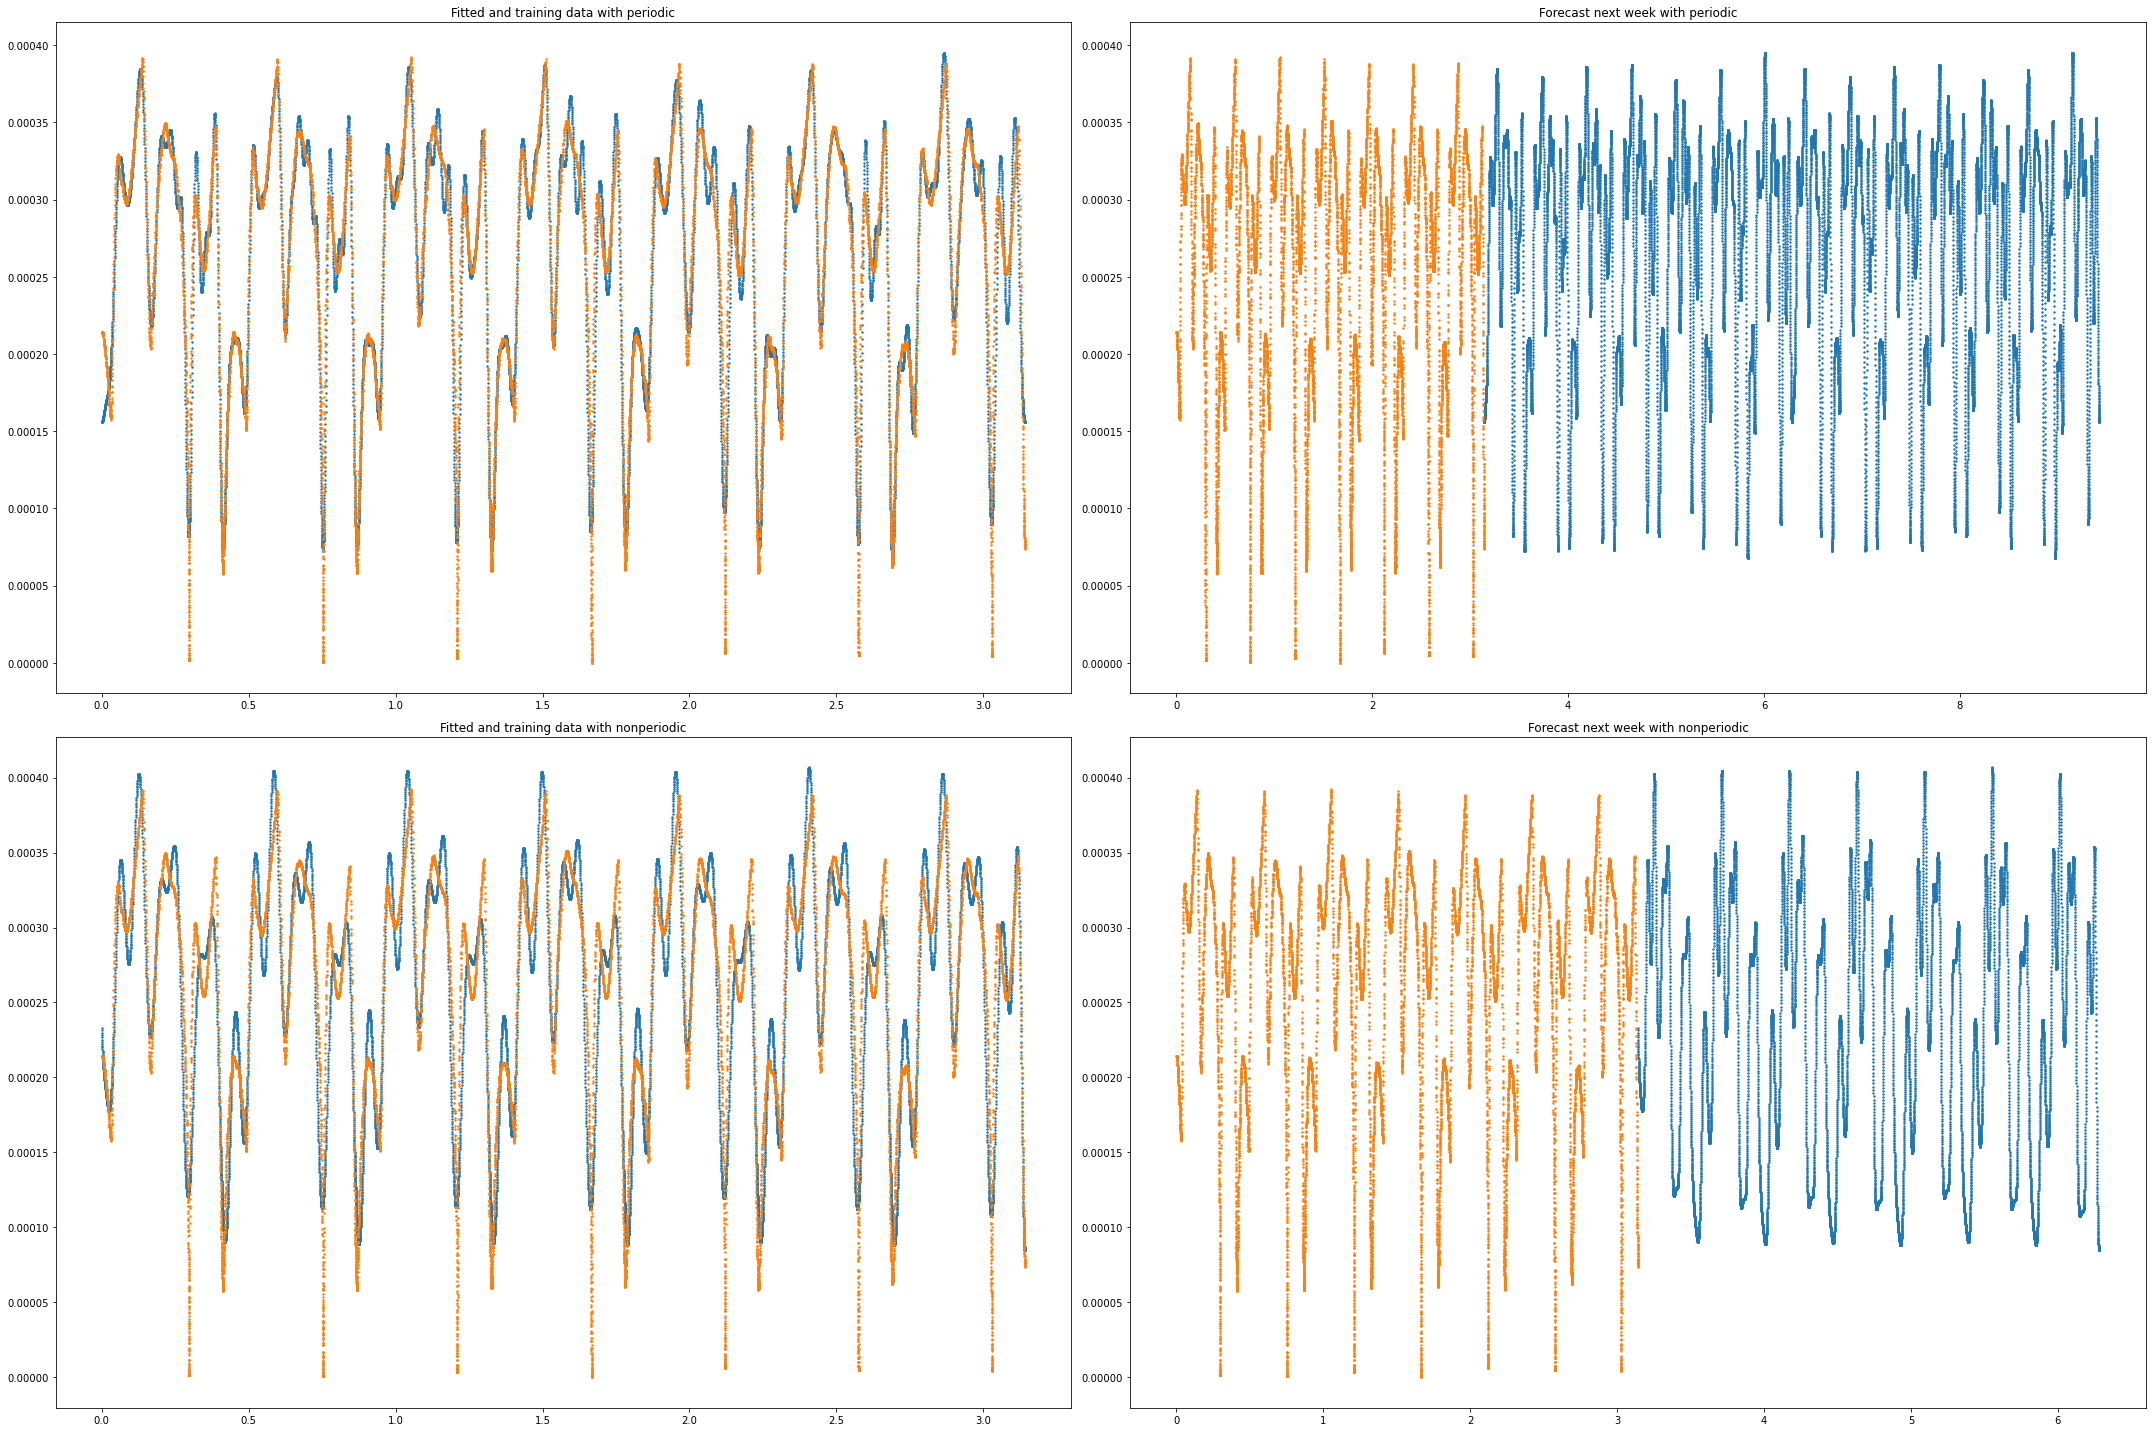

In [67]:
fig, ax = plt.subplots(2,2,figsize=(30,20))

ax[0][0].scatter(arclength, periodic_train, s=2)
ax[0][0].scatter(arclength, arclengthdot, s=2)
ax[0][0].set_title("Fitted and training data with periodic")

#ax[0][1].scatter(next_weeks[:int(len(next_weeks)/2)], periodic_pred[:int(len(next_weeks)/2)], s=2)
ax[0][1].scatter(next_weeks, periodic_pred, s=2)
ax[0][1].scatter(arclength, arclengthdot, s=2)
ax[0][1].set_title("Forecast next week with periodic")

ax[1][0].scatter(arclength, nonperiodic_train, s=2)
ax[1][0].scatter(arclength, arclengthdot, s=2)
ax[1][0].set_title("Fitted and training data with nonperiodic")

ax[1][1].scatter(next_weeks[:int(len(next_weeks)/2)], nonperiodic_train[:int(len(next_weeks)/2)], s=2)
ax[1][1].scatter(arclength, arclengthdot, s=2)
ax[1][1].set_title("Forecast next week with nonperiodic")

fig.tight_layout()

## Subtask 4


### Learn measurement area 1 from arclength

Text(0, 0.5, 'Number of people in area 1')

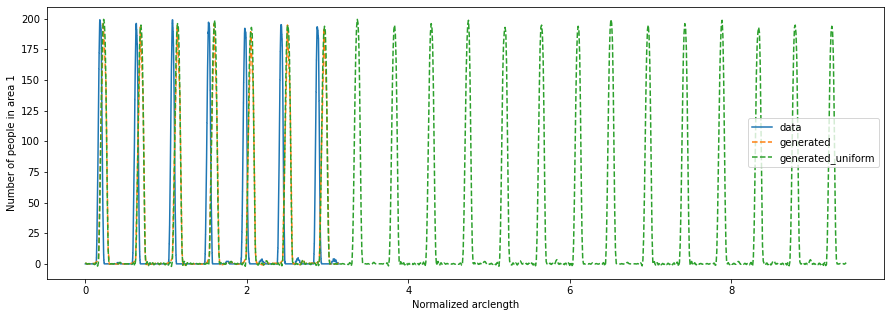

In [70]:
plt.figure(figsize=(15,5))
rbf_area1 = RBF(200, 0.05, periodic=True)
rbf_area1.fit(arclength, mi[0:len(arclength),1])
generated = rbf_area1.predict(arclength[::100])
generated_uniform = rbf_area1.predict(np.linspace(0,3*np.pi, 1000))
plt.plot(np.linspace(0,np.pi, len(mi[:,1])), mi[:,1], label='data')
plt.plot(arclength[::100], generated,'--',label='generated')
plt.plot(np.linspace(0,3*np.pi, 1000), generated_uniform,'--',label='generated_uniform')
plt.legend()
plt.xlabel('Normalized arclength')
plt.ylabel('Number of people in area 1')

### Predict measurement area 1 from time

Text(0, 0.5, 'Number of people in area 1')

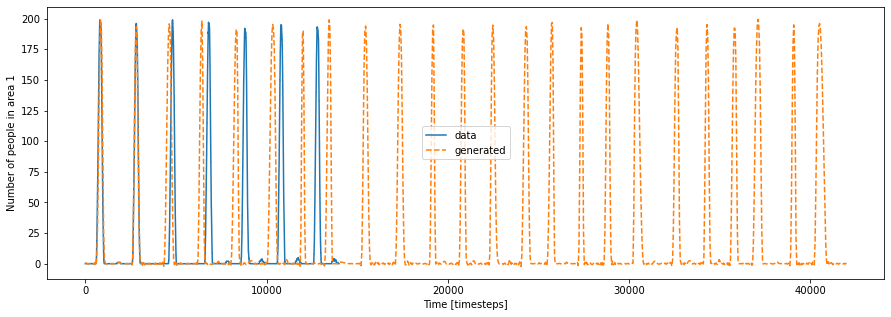

In [72]:
plt.figure(figsize=(15,5))
t1 = 42000
t = np.linspace(0,t1,1000)
s0 = np.array([0.])
sol = solve_ivp(lambda t,x: rbf_periodic.predict(x), (0,t1), s0, t_eval=t)
prediction_times = sol.t
prediction_area1 = rbf_area1.predict(sol.y.T)
plt.plot(mi[:,0]-1000,mi[:,1],label='data')
plt.plot(t,prediction_area1,'--',label='generated')
plt.legend()
plt.xlabel('Time [timesteps]')
plt.ylabel('Number of people in area 1')